<a href="https://colab.research.google.com/github/alina-bogdanovskaya/ML_in_Business_Mar2023/blob/lesson2/ML_in_busines_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# !pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=327f325fa21438edc95b0987fb03d637233211651b6e24911f1ab66ef9d76acf
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [63]:
import pandas as pd
import numpy as np
import re
import sys
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2

In [4]:
news = pd.read_csv('/content/drive/MyDrive/GB/ML in business/Lection2-20220325T130258Z-001/Lection2/materials.csv')
users = pd.read_csv('/content/drive/MyDrive/GB/ML in business/Lection2-20220325T130258Z-001/Lection2/users_articles.csv')

In [5]:
news.head()

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [6]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [7]:
import nltk
nltk.download('stopwords')

stopword_ru = stopwords.words('russian')
len(stopword_ru)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


151

In [8]:
morph = pymorphy2.MorphAnalyzer()

In [9]:
with open('/content/drive/MyDrive/GB/ML in business/Lection2-20220325T130258Z-001/Lection2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-10-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 41.7 s, sys: 883 ms, total: 42.6 s
Wall time: 52.1 s


In [12]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 11s, sys: 683 ms, total: 4min 12s
Wall time: 4min 15s


In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [88]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
n_topics = 25
lda = LdaModel(common_corpus, num_topics=n_topics, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 56s, sys: 58.8 s, total: 2min 55s
Wall time: 2min 3s


In [15]:
# from gensim.test.utils import datapath
# # Save model to disk.
# temp_file = datapath("model.lda")
# lda.save(temp_file)

# # Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.05261812), (5, 0.9262436)]

In [89]:
x = lda.show_topics(num_topics=n_topics, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: учёный университет журнал русский древний nn музей новый образование церковь
topic_1: млрд военный средство помощь привести миссия новый население расследование писать
topic_2: банк фонд nn министр правительство медведев глава белоруссия заседание товар
topic_3: газ погибнуть взрыв турецкий китайский китай турция nn агентство россия
topic_4: корабль украина армия море северный украинский вода экипаж российский астероид
topic_5: проект развитие рынок новый население инвестор регион рабочий россия стоимость
topic_6: связанный тело останки ссср советский кровь первый сын пища вскоре
topic_7: космический космос фестиваль мкс nn лаборатория nasa астронавт исследование программа
topic_8: век производитель тыс составить конкурс следователь организм рак млн метеорит
topic_9: ребёнок рубль мозг руб nn санкция тыс семья турист размер
topic_10: научный учёный снижение наука спутник эксперимент солнечный форум эксперт новый
topic_11: исследователь женщина жизнь писать мужчина nn болезнь в

In [90]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [91]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(n_topics)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(n_topics)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.788458,0.000000,0.0,0.0,0.030576,0.000000,0.055075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.118832,0.0,0.000000
1,4896,0.0,0.000000,0.000000,0.348424,0.0,0.0,0.199222,0.235055,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.196811,0.000000,0.0,0.000000
2,4897,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.074898,0.296007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.050209
3,4898,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.124008,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,4899,0.0,0.361953,0.436877,0.000000,0.0,0.0,0.000000,0.000000,0.143453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.035014


In [92]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(n_topics)]].values))

In [94]:
users.articles = users.articles.apply(lambda x: ''.join([i.strip() for i in x.replace('[', '').replace(']', '')]), 1)
users.articles.head()

0    293672,293328,293001,293622,293126,1852
1            3405,1739,2972,1158,1599,322665
2            1845,2009,2356,1424,2939,323389
3            5933,6186,5055,6977,5206,488389
4             707,1144,2532,2928,3133,324592
Name: articles, dtype: object

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(users.articles)
feature_names = [int(i) for i in tfidf.get_feature_names_out()]

In [96]:
idf = pd.DataFrame({'article_id': feature_names, 'idf': tfidf.idf_})
idf_dict = dict(zip(idf.article_id.values, idf.idf.values))

In [97]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector


def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector


def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector   


def get_user_embedding_idf(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id]*idf_dict[doc_id] for doc_id in user_articles_list if doc_id in idf_dict])
    user_vector = np.mean(user_vector, 0)
    return user_vector    

In [98]:
user_articles_list = users['articles'].iloc[33]
get_user_embedding_mean(user_articles_list)

array([0.02002952, 0.03029984, 0.03908871, 0.        , 0.03299198,
       0.03828776, 0.        , 0.        , 0.01042194, 0.16842092,
       0.00801528, 0.0655234 , 0.00662509, 0.00371267, 0.        ,
       0.04943848, 0.03270276, 0.00251537, 0.        , 0.20273262,
       0.06409591, 0.05553326, 0.005244  , 0.14767369, 0.00398481])

In [99]:
users['articles'].iloc[33]

'323329,321961,324743,323186,324632,474690'

In [100]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

In [101]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.140596,0.020687,0.042779,0.041459,0.000000,0.000000,0.047316,0.029333,0.006287,...,0.017602,0.006033,0.008742,0.000000,0.061327,0.023661,0.012973,0.017220,0.168391,0.138509
1,u108690,0.024789,0.071083,0.019187,0.014221,0.005263,0.029160,0.011037,0.013925,0.025129,...,0.000000,0.015708,0.010978,0.012515,0.182408,0.011015,0.030935,0.002944,0.130079,0.016434
2,u108339,0.037451,0.059803,0.042720,0.056474,0.004723,0.009456,0.000000,0.000000,0.038034,...,0.137294,0.015902,0.005200,0.024905,0.090268,0.016393,0.038460,0.002011,0.076917,0.009070


In [102]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.055255,0.000000,0.000000,0.000000,0.0,0.000000,0.022871,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009701,0.064528,0.071154
1,u108690,0.000000,0.082191,0.007069,0.000000,0.0,0.032643,0.000000,0.0,0.017684,...,0.00000,0.007999,0.008225,0.007696,0.088851,0.005995,0.005059,0.000000,0.112618,0.000000
2,u108339,0.009859,0.058802,0.023965,0.016437,0.0,0.000000,0.000000,0.0,0.031845,...,0.18225,0.005306,0.000000,0.008538,0.083003,0.006399,0.031328,0.000000,0.054861,0.000000


In [103]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.371009,0.085888,0.145713,0.248753,0.000000,0.000000,0.180662,0.175999,0.037720,...,0.060056,0.036201,0.052449,0.000000,0.256047,0.086788,0.077836,0.043748,0.566770,0.372577
1,u108690,0.148732,0.134707,0.069754,0.074231,0.031576,0.063457,0.066224,0.083550,0.058476,...,0.000000,0.040153,0.026082,0.034962,0.433312,0.027271,0.116887,0.017663,0.234601,0.086115
2,u108339,0.176448,0.107529,0.172602,0.217540,0.015817,0.034979,0.000000,0.000000,0.102843,...,0.245118,0.052973,0.015822,0.069523,0.278285,0.060528,0.075283,0.012065,0.155452,0.031767


In [104]:
user_embeddings_idf = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_idf(x), 1)])
user_embeddings_idf.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_idf['uid'] = users['uid'].values
user_embeddings_idf = user_embeddings_idf[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_idf.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,1.191330,0.177932,0.367942,0.356588,0.000000,0.000000,0.394760,0.252295,0.058430,...,0.151395,0.050548,0.075186,0.000000,0.523104,0.197641,0.111579,0.151437,1.432609,1.213988
1,u108690,0.220339,0.600029,0.163596,0.131422,0.046779,0.246456,0.085982,0.114123,0.215512,...,0.000000,0.130724,0.096647,0.109467,1.531040,0.097414,0.257469,0.027360,1.122000,0.144631
2,u108339,0.300231,0.503520,0.361361,0.503670,0.040036,0.078156,0.000000,0.000000,0.323245,...,1.150822,0.140057,0.045915,0.199935,0.750169,0.140227,0.327111,0.018688,0.654932,0.080150


In [105]:
target = pd.read_csv('/content/drive/MyDrive/GB/ML in business/Lection2-20220325T130258Z-001/Lection2/users_churn.csv')
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [106]:
X1 = pd.merge(user_embeddings_mean, target, 'left')
X2 = pd.merge(user_embeddings_median, target, 'left')
X3 = pd.merge(user_embeddings_max, target, 'left')
X4 = pd.merge(user_embeddings_idf, target, 'left')

In [107]:
X1.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.140596,0.020687,0.042779,0.041459,0.000000,0.000000,0.047316,0.029333,0.006287,...,0.006033,0.008742,0.000000,0.061327,0.023661,0.012973,0.017220,0.168391,0.138509,0
1,u108690,0.024789,0.071083,0.019187,0.014221,0.005263,0.029160,0.011037,0.013925,0.025129,...,0.015708,0.010978,0.012515,0.182408,0.011015,0.030935,0.002944,0.130079,0.016434,1
2,u108339,0.037451,0.059803,0.042720,0.056474,0.004723,0.009456,0.000000,0.000000,0.038034,...,0.015902,0.005200,0.024905,0.090268,0.016393,0.038460,0.002011,0.076917,0.009070,1
3,u101138,0.000000,0.015399,0.007836,0.020333,0.022712,0.012616,0.027293,0.101854,0.034056,...,0.000000,0.015394,0.003910,0.099534,0.121719,0.047118,0.140991,0.005012,0.000000,0
4,u108248,0.035956,0.017789,0.021022,0.014729,0.042610,0.017809,0.020698,0.002862,0.025792,...,0.052029,0.021044,0.034583,0.102074,0.021440,0.054737,0.028603,0.096942,0.033969,1


In [108]:
X2.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.055255,0.000000,0.000000,0.000000,0.0,0.000000,0.022871,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009701,0.064528,0.071154,0
1,u108690,0.000000,0.082191,0.007069,0.000000,0.0,0.032643,0.000000,0.00000,0.017684,...,0.007999,0.008225,0.007696,0.088851,0.005995,0.005059,0.000000,0.112618,0.000000,1
2,u108339,0.009859,0.058802,0.023965,0.016437,0.0,0.000000,0.000000,0.00000,0.031845,...,0.005306,0.000000,0.008538,0.083003,0.006399,0.031328,0.000000,0.054861,0.000000,1
3,u101138,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.04063,0.000000,...,0.000000,0.000000,0.000000,0.020156,0.023463,0.039335,0.013745,0.000000,0.000000,0
4,u108248,0.031726,0.000000,0.005574,0.000000,0.0,0.009003,0.000000,0.00000,0.012736,...,0.000000,0.000000,0.006504,0.079486,0.006943,0.024957,0.000000,0.084022,0.018966,1


In [109]:
X3.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.371009,0.085888,0.145713,0.248753,0.000000,0.000000,0.180662,0.175999,0.037720,...,0.036201,0.052449,0.000000,0.256047,0.086788,0.077836,0.043748,0.566770,0.372577,0
1,u108690,0.148732,0.134707,0.069754,0.074231,0.031576,0.063457,0.066224,0.083550,0.058476,...,0.040153,0.026082,0.034962,0.433312,0.027271,0.116887,0.017663,0.234601,0.086115,1
2,u108339,0.176448,0.107529,0.172602,0.217540,0.015817,0.034979,0.000000,0.000000,0.102843,...,0.052973,0.015822,0.069523,0.278285,0.060528,0.075283,0.012065,0.155452,0.031767,1
3,u101138,0.000000,0.092397,0.047014,0.122000,0.136271,0.075694,0.116663,0.324042,0.204338,...,0.000000,0.057238,0.023463,0.469877,0.614133,0.124408,0.701662,0.030073,0.000000,0
4,u108248,0.097858,0.053440,0.067392,0.088375,0.209117,0.045677,0.099009,0.017171,0.112475,...,0.312172,0.097348,0.113615,0.293914,0.058379,0.192574,0.146594,0.256904,0.117545,1


In [110]:
X4.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,1.191330,0.177932,0.367942,0.356588,0.000000,0.000000,0.394760,0.252295,0.058430,...,0.050548,0.075186,0.000000,0.523104,0.197641,0.111579,0.151437,1.432609,1.213988,0
1,u108690,0.220339,0.600029,0.163596,0.131422,0.046779,0.246456,0.085982,0.114123,0.215512,...,0.130724,0.096647,0.109467,1.531040,0.097414,0.257469,0.027360,1.122000,0.144631,1
2,u108339,0.300231,0.503520,0.361361,0.503670,0.040036,0.078156,0.000000,0.000000,0.323245,...,0.140057,0.045915,0.199935,0.750169,0.140227,0.327111,0.018688,0.654932,0.080150,1
3,u101138,0.000000,0.129015,0.065646,0.170350,0.190277,0.105692,0.223682,0.872186,0.292919,...,0.000000,0.133843,0.032049,0.848713,1.001085,0.404451,1.177237,0.041078,0.000000,0
4,u108248,0.296879,0.149389,0.170272,0.123400,0.355567,0.147307,0.168791,0.023975,0.216117,...,0.418385,0.174684,0.285681,0.843629,0.176977,0.463250,0.230653,0.800174,0.279044,1


In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [112]:
#разделим данные на train/test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1[['topic_{}'.format(i) for i in range(n_topics)]], 
                                                        X1['churn'], random_state=42)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2[['topic_{}'.format(i) for i in range(n_topics)]], 
                                                        X2['churn'], random_state=42)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3[['topic_{}'.format(i) for i in range(n_topics)]], 
                                                        X3['churn'], random_state=42)

X4_train, X4_test, y4_train, y4_test = train_test_split(X4[['topic_{}'.format(i) for i in range(n_topics)]], 
                                                        X4['churn'], random_state=42)

In [37]:
target.churn.value_counts()/target.shape[0]

0    0.875
1    0.125
Name: churn, dtype: float64

In [38]:
w = {0:.875, 1:.125}

In [113]:
logreg1 = LogisticRegression(random_state=13, class_weight=w)
logreg2 = LogisticRegression(random_state=13, class_weight=w)
logreg3 = LogisticRegression(random_state=13, class_weight=w)
logreg4 = LogisticRegression(random_state=13, class_weight=w)
#обучим 
logreg1.fit(X1_train, y1_train)
logreg2.fit(X2_train, y2_train)
logreg3.fit(X3_train, y3_train)
logreg4.fit(X4_train, y4_train)

LogisticRegression(class_weight={0: 0.875, 1: 0.125}, random_state=13)

In [114]:
#наши прогнозы для тестовой выборки - cреднее
preds1 = logreg1.predict_proba(X1_test)[:, 1]
preds1[:10]

array([0.00672071, 0.02027476, 0.00956599, 0.02017966, 0.02068255,
       0.02334464, 0.00941848, 0.0341166 , 0.03177548, 0.01874716])

In [115]:
#наши прогнозы для тестовой выборки - медиана
preds2 = logreg2.predict_proba(X2_test)[:, 1]
preds2[:10]

array([0.01431168, 0.01642054, 0.01203959, 0.01954195, 0.02171371,
       0.01840446, 0.01206754, 0.04264026, 0.03469375, 0.01864897])

In [116]:
#наши прогнозы для тестовой выборки - максимум
preds3 = logreg3.predict_proba(X3_test)[:, 1]
preds3[:10]

array([0.000333  , 0.00533481, 0.00182767, 0.00640877, 0.01885132,
       0.02093538, 0.00116037, 0.0151278 , 0.13432659, 0.00555384])

In [117]:
#наши прогнозы для тестовой выборки - tfidf
preds4 = logreg4.predict_proba(X4_test)[:, 1]
preds4[:10]

array([9.39074174e-07, 1.26655155e-03, 1.05596924e-04, 4.12634107e-03,
       7.89261014e-03, 1.37483801e-02, 9.95689535e-06, 2.72279116e-02,
       2.00263130e-01, 2.99469153e-03])

In [78]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

In [118]:
precision1, recall1, thresholds1 = precision_recall_curve(y1_test, preds1)
print(precision1)
print(recall1)
print(thresholds1)
fscore1 = (2 * precision1 * recall1) / (precision1 + recall1 + sys.float_info.epsilon)
# locate the index of the largest f score
ix1 = np.argmax(fscore1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds1[ix1], 
                                                                        fscore1[ix1],
                                                                        precision1[ix1],
                                                                        recall1[ix1]))

[0.1265     0.12656328 0.12662663 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00790514 0.00395257 0.        ]
[0.00605384 0.00623893 0.00641808 ... 0.05042897 0.05156786 0.05222169]
Best Threshold=0.028526, F-Score=0.603, Precision=0.539, Recall=0.684


In [119]:
precision2, recall2, thresholds2 = precision_recall_curve(y2_test, preds2)
print(precision2)
print(recall2)
print(thresholds2)
fscore2 = (2 * precision2 * recall2) / (precision2 + recall2 + sys.float_info.epsilon)
# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

[0.1265     0.12656328 0.12662663 ... 0.5        1.         1.        ]
[1.         1.         1.         ... 0.00395257 0.00395257 0.        ]
[0.00862815 0.00874661 0.01005845 ... 0.06617148 0.07511025 0.07948502]
Best Threshold=0.032382, F-Score=0.653, Precision=0.689, Recall=0.621


In [120]:
precision3, recall3, thresholds3 = precision_recall_curve(y3_test, preds3)
print(precision3)
print(recall3)
print(thresholds3)
fscore3 = (2 * precision3 * recall3) / (precision3 + recall3 + sys.float_info.epsilon)
# locate the index of the largest f score
ix3 = np.argmax(fscore3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds3[ix3], 
                                                                        fscore3[ix3],
                                                                        precision3[ix3],
                                                                        recall3[ix3]))

[0.1265     0.12656328 0.12662663 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00790514 0.00395257 0.        ]
[5.17146633e-05 7.47947251e-05 7.82044329e-05 ... 2.45726410e-01
 2.60451036e-01 2.71669050e-01]
Best Threshold=0.054783, F-Score=0.743, Precision=0.702, Recall=0.791


In [121]:
precision4, recall4, thresholds4 = precision_recall_curve(y4_test, preds4)
print(precision4)
print(recall4)
print(thresholds4)
fscore4 = (2 * precision4 * recall4) / (precision4 + recall4 + sys.float_info.epsilon)
# locate the index of the largest f score
ix4 = np.argmax(fscore4)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds4[ix4], 
                                                                        fscore4[ix4],
                                                                        precision4[ix4],
                                                                        recall4[ix4]))

[0.1265     0.12656328 0.12662663 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00790514 0.00395257 0.        ]
[2.17283770e-08 2.41061026e-08 1.04442694e-07 ... 8.42351104e-01
 8.87783690e-01 9.04356034e-01]
Best Threshold=0.076815, F-Score=0.757, Precision=0.784, Recall=0.731


In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1599  148]
 [  81  172]]


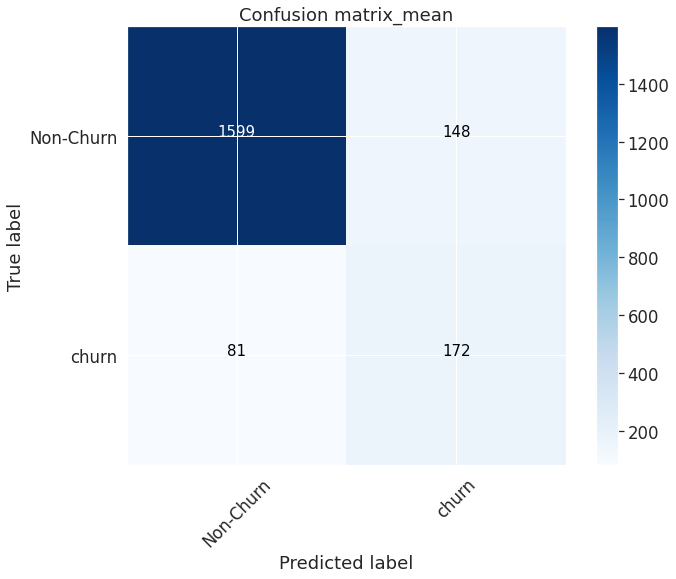

In [122]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix1 = confusion_matrix(y1_test, preds1>thresholds1[ix1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix1, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_mean')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1676   71]
 [  97  156]]


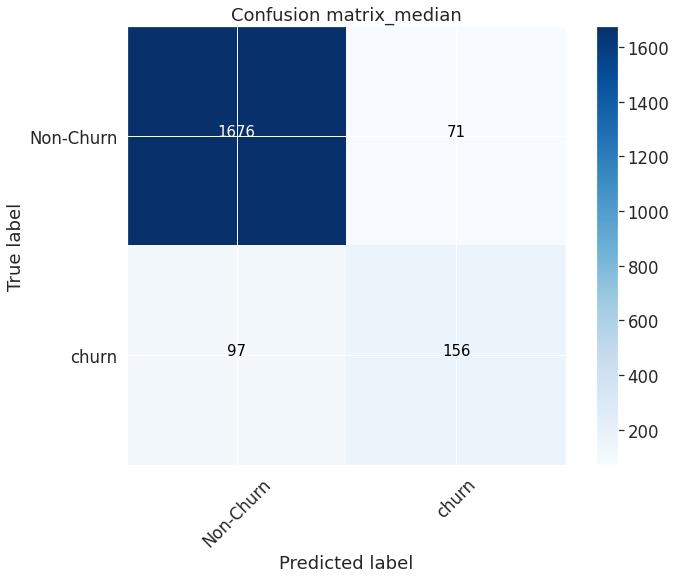

In [123]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix2 = confusion_matrix(y2_test, preds2>thresholds2[ix2])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix2, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_median')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1662   85]
 [  54  199]]


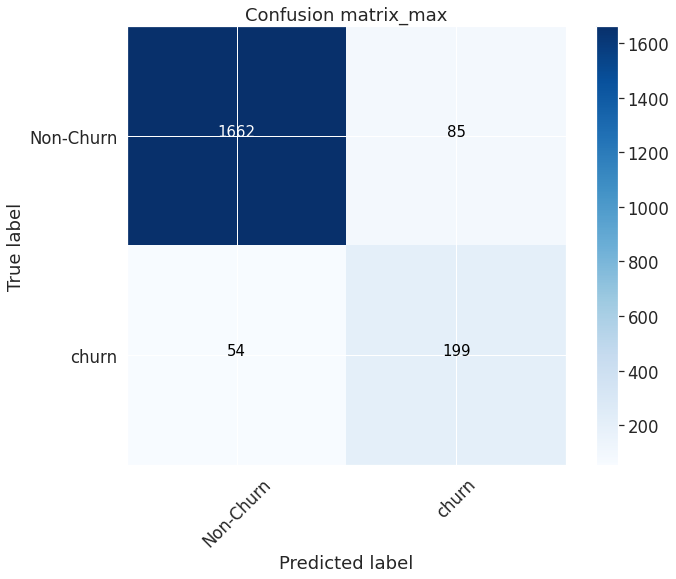

In [124]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix3 = confusion_matrix(y3_test, preds3>thresholds3[ix3])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix3, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_max')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1696   51]
 [  69  184]]


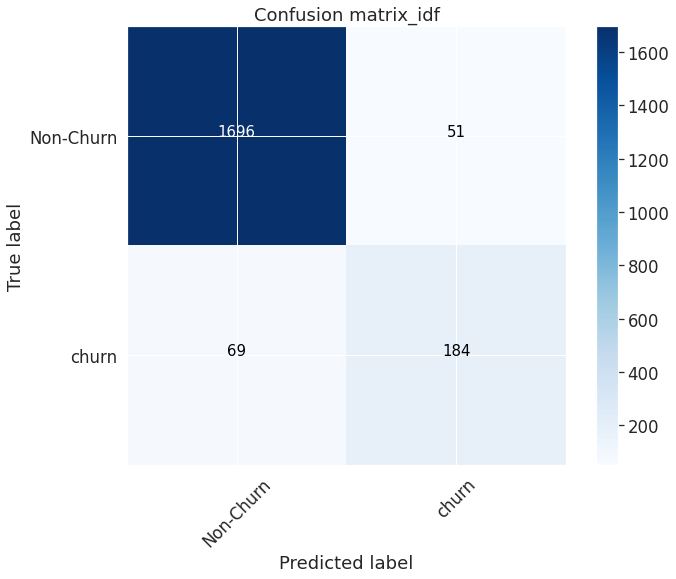

In [125]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix4 = confusion_matrix(y4_test, preds4>thresholds4[ix4])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix4, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_idf')
plt.savefig("conf_matrix.png")
plt.show()

In [126]:
roc_mean = roc_auc_score(y1_test, preds1)
roc_median = roc_auc_score(y2_test, preds2)
roc_max = roc_auc_score(y3_test, preds3)
roc_idf = roc_auc_score(y4_test, preds4)

roc_mean, roc_median, roc_max, roc_idf

(0.9205888807690654, 0.9385191101176269, 0.964800188239127, 0.9641463287714004)

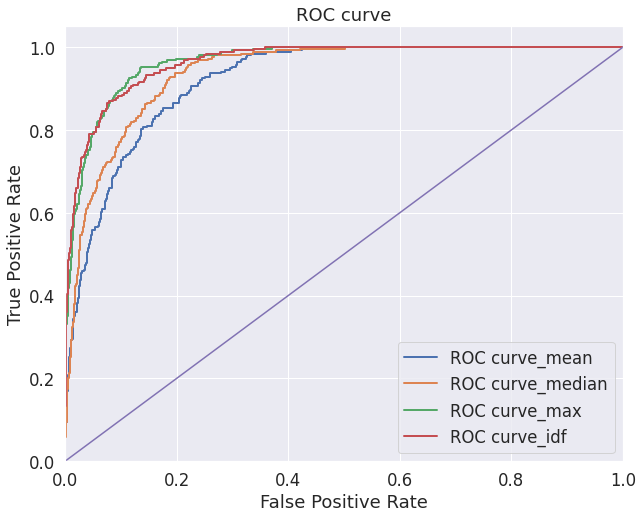

In [127]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr1, tpr1, thresholds1_ = roc_curve(y1_test, preds1, pos_label=1)
fpr2, tpr2, thresholds2_ = roc_curve(y2_test, preds2, pos_label=1)
fpr3, tpr3, thresholds3_ = roc_curve(y3_test, preds3, pos_label=1)
fpr4, tpr4, thresholds4_ = roc_curve(y4_test, preds4, pos_label=1)
lw = 2
plt.plot(fpr1, tpr1, lw=lw, label='ROC curve_mean')
plt.plot(fpr2, tpr2, lw=lw, label='ROC curve_median')
plt.plot(fpr3, tpr3, lw=lw, label='ROC curve_max')
plt.plot(fpr4, tpr4, lw=lw, label='ROC curve_idf')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# plt.savefig("ROC.png")
plt.show()

In [128]:
data = {'Value': ['mean', 'median', 'max', 'idf'], 
        'ROC_AUC': [f'{roc_mean}', f'{roc_median}', f'{roc_max}', f'{roc_idf}'],
        'Threshold': [f'{thresholds1[ix1]}', f'{thresholds2[ix2]}', f'{thresholds3[ix3]}', f'{thresholds4[ix4]}'], 
        'F_score': [f'{fscore1[ix1]}', f'{fscore2[ix2]}', f'{fscore3[ix3]}', f'{fscore4[ix4]}'],
        'Precision': [f'{precision1[ix1]}', f'{precision2[ix2]}', f'{precision3[ix3]}', f'{precision4[ix4]}'],
        'Recall': [f'{recall1[ix1]}', f'{recall2[ix2]}', f'{recall3[ix3]}', f'{recall4[ix4]}']}
result = pd.DataFrame(data)
result

,Value,ROC_AUC,Threshold,F_score,Precision,Recall
0,mean,0.9205888807690654,0.0285255466727641,0.602787456445993,0.5389408099688473,0.6837944664031621
1,median,0.9385191101176269,0.03238165462287428,0.6528066528066527,0.6885964912280702,0.6205533596837944
2,max,0.964800188239127,0.05478280909462302,0.7434944237918214,0.7017543859649122,0.7905138339920948
3,idf,0.9641463287714004,0.07681453613998449,0.7566462167689161,0.7838983050847458,0.7312252964426877
